# Implementation of 4DVarNet in JAX

Our project aims to implement 4DVarNet, a neural network model for data assimilation, in the JAX framework. The standard implementation of 4DVarNet is in PyTorch. We want to implement the corresponding codes leveraging efficient packages in the JAX ecosystem.

The optimal solution $X_{i}^{*}$ minimizes a cost function  

 $$  X^{i*}= \min_{X^i} \mathbf{U}_\Phi \left(X^i,Y^i,\Omega^i\right)
$$ where U denotes the 4DVar cost, given by,
   $$ \mathbf{U}_\Phi \left(X^i,Y^i\right)= \|H(X^i)-Y^i\|+ \|X^i- \Phi(X^i)\|$$

4DVarNet solves the above weak-constraint problem to obtain a trajectory over the assimilation window by learning both $\Phi$ and

We also have a **Neural Solver** ,
     $\Gamma\left(U_\Phi, X^{init}, Y\right)$: A network that learns to efficiently solve a class of similar 4DVAR optimization problems.   
   which is implemented in the following manner:
   $$X^{k+1}=X^k-P(g_k), \ g_k=\mathcal{S}_\theta(\nabla_X \mathbf{U}_\Phi \left(X^i,Y^i\right)), $$
where $\mathcal{S}_{\theta}$: ConvLSTM model.


We implement 4DVarNet for a small toy problem where we generate a dataset using Lorenz-63 simulations. The assimilation window has 5 time points, and each time point has $\left[x,y,z\right]^T$. The corresponding observations are $\left[x+ \mathcal{N}(0,\sigma),y+ \mathcal{N}(0,\sigma)\right]$.


## 1. Import Libraries and Load Data

In [ ]:
import os
import jax
import torch
import numpy as np
import jax.numpy as jnp
import jax.random as random
from jax.experimental.ode import odeint
from jax import lax
from jax.tree_util import tree_map
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
from torch.utils import data
from torch.utils.data import Dataset, DataLoader

## 2. Initialize models and generate data

In [ ]:
class L63_true:
    def __init__(self, state_dim= 3, sigma= 10.0, rho= 28.0, beta= 8.0 / 3.0):
        self.state_dim = state_dim
        self.sigma = sigma
        self.rho = rho
        self.beta = beta

    def dyn_sys(self, x, t) -> jnp.ndarray:
        x1, x2, x3 = x
        dx1_dt = self.sigma * (x2 - x1)
        dx2_dt = x1 * (self.rho - x3) - x2
        dx3_dot = x1 * x2 - self.beta * x3
        dx_dt= jnp.array([dx1_dt, dx2_dt, dx3_dot])
        return dx_dt

    def __call__(self, x0, dt, steps , params_submodel= None) -> jnp.ndarray:
        def time_step( x, dt) -> jnp.ndarray:
            t0= 0.0
            t = jnp.array([t0, t0 + dt])
            x_next = odeint(self.dyn_sys, x, t)
            return x_next[-1, :]

        def rollout(stepper_fn, n_rollsteps, *_, include_x0=True):

            def scan_fn(x, _):
                x_next = stepper_fn(x, dt)
                return x_next, x_next

            def rollout_fn(x0):
                _, traj = lax.scan(scan_fn, x0, length= n_rollsteps)
                if include_x0:
                    return jnp.concatenate([jnp.expand_dims(x0, axis=0), traj], axis=0)
                else:
                    return traj
            return rollout_fn

        traj = rollout(time_step, steps)(x0)
        return traj

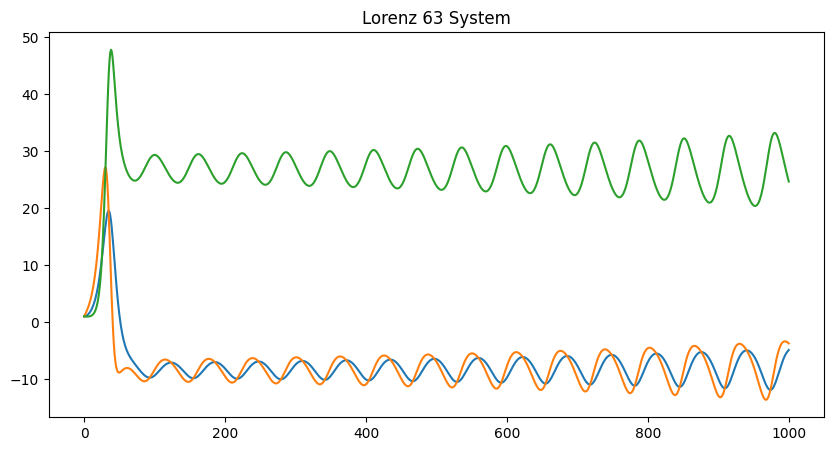

In [20]:

l63_model = L63_true()
x0= jnp.array([1.0, 1.0, 1.0])
dt= 0.01
nsteps= 1000
l63_traj= l63_model(x0, dt, nsteps)

# Normalize the data
l63_traj_norm = (l63_traj - l63_traj.mean(axis=0)) / l63_traj.std(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(l63_traj[:, :])
ax.set_title('Lorenz 63 System')
plt.show()


## 3. Define dataloaders

In [21]:
# Here we keep pytorch dataloaders

def numpy_collate(batch):
    return tree_map(jnp.array, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)
# -----------------------------------------------------------------
class LorenzDataset(Dataset):
    def __init__(self, x_traj, seq_len=10, noise_std=0.1):
        """
        x_traj: Correct Lorenz system trajectory (True model)
        seq_len: Length of sequences to be used as training data
        noise_std: Standard deviation of Gaussian noise
        """
        self.x_traj = np.array(x_traj)  # Keep all three components for x
        self.y_traj = self.x_traj[:, :2]  # Keep only (x, y) for y
        self.seq_len = seq_len
        self.noise_std = noise_std

    def __len__(self):
        return len(self.x_traj) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.x_traj[idx:idx + self.seq_len]  # (seq_len, 3)
        y_seq = self.y_traj[idx:idx + self.seq_len]  # (seq_len, 2)
        noise = np.random.normal(0, self.noise_std, y_seq.shape)  # Gaussian noise
        y_noisy = y_seq + noise  # Apply noise to (x, y)

        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_noisy, dtype=torch.float32)

In [22]:
# Define sequence length and batch size
len_seq = 5
batch_size = 20

# Create dataset
dataset = LorenzDataset(l63_traj, len_seq, noise_std=0.1)
# Create NumpyLoader
dataloaders = NumpyLoader(dataset, batch_size=batch_size, shuffle=True)

print('Number of batches:', len(dataloaders))
print('Shape in each batch:')

def get_dataloader_shape(dataloaders):
    for x, y in dataloaders:
        x_shape= x.shape
        y_shape= y.shape
        break
    return x_shape, y_shape

print(get_dataloader_shape(dataloaders))

Number of batches: 50
Shape in each batch:
((20, 5, 3), (20, 5, 2))


## 4. Define NN Architecture (ConvLSTM)

In [23]:
class SimpleFC(nn.Module):
    hidden_dim: int
    output_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.output_dim)(x)
        return x


# -----------------------------------------------------------------------------
class ConvLSTM(nn.Module):
    """ConvLSTM module in JAX using Flax, returns all hidden states."""
    input_dim: int       # Number of input channels
    hidden_dim: int      # Number of hidden state channels
    kernel_size: int = 3 # Kernel size for convolution

    def setup(self):
        """Define layers."""
        self.gates = nn.Conv(self.hidden_dim * 4, (self.kernel_size, self.kernel_size), padding="SAME")
        self.conv_out = nn.Conv(self.input_dim, (self.kernel_size, self.kernel_size), padding="SAME")

    def convlstm_cell(self, x, hidden, cell):
        """Single ConvLSTM cell step."""
        gates = self.gates(jnp.concatenate([x, hidden], axis=-1))  # Compute gates
        in_gate, remember_gate, out_gate, cell_gate = jnp.split(gates, 4, axis=-1)

        # Apply activation functions
        in_gate, remember_gate, out_gate = map(nn.sigmoid, [in_gate, remember_gate, out_gate])
        cell_gate = jnp.tanh(cell_gate)

        # Update cell and hidden state
        cell = remember_gate * cell + in_gate * cell_gate
        hidden = out_gate * jnp.tanh(cell)
        return hidden, cell

    def __call__(self, x, hidden=None, cell=None):
        """
        Forward pass through ConvLSTM.
        x: (batch, seq_len, height, width, input_dim)
        """
        batch, seq_len, height, width, _ = x.shape

        # Initialize hidden and cell states if not provided
        if hidden is None:
            hidden = jnp.zeros((batch, height, width, self.hidden_dim))
            cell = jnp.zeros((batch, height, width, self.hidden_dim))

        all_outputs = []

        # Process each timestep
        for t in range(seq_len):
            hidden, cell = self.convlstm_cell(x[:, t], hidden, cell)
            all_outputs.append(self.conv_out(hidden))  # Apply conv_out to the hidden state

        # out = self.conv_out(hidden)  # Apply final convolution on the last hidden state
        out= jnp.stack(all_outputs, axis=1)

        # Return all hidden states
        return out  # Shape: (batch, seq_len, height, width, hidden_dim)
# -----------------------------------------------------------------------------

class BilinearAutoencoder(nn.Module):
    hidden_dim: int  # Dimension of the latent space

    def setup(self):
        # Encoder: Compress the input to a latent space
        self.encoder_fc = nn.Dense(self.hidden_dim)  # Fully connected layer
        self.encoder_bilinear = nn.Dense(self.hidden_dim)  # Bilinear transformation

        # Decoder: Reconstruct the input from the latent space
        self.decoder_fc = nn.Dense(self.hidden_dim)  # Fully connected layer
        self.decoder_bilinear = nn.Dense(self.hidden_dim)  # Bilinear transformation
        self.decoder_final = nn.Dense(3)  # Output layer with 3 channels (to match y)

    def encode(self, x):
        """Encoder transforms the input data into a latent space."""
        x = self.encoder_fc(x)  # Compress the input
        x = jax.nn.relu(x)  # Apply ReLU activation
        latent = self.encoder_bilinear(x)  # Apply bilinear transformation
        return latent

    def decode(self, z):
        """Decoder reconstructs the original input from the latent space."""
        z = self.decoder_fc(z)  # Expand latent space back
        z = jax.nn.relu(z)  # Apply ReLU activation
        z = self.decoder_bilinear(z)  # Apply bilinear transformation
        reconstruction = self.decoder_final(z)  # Reconstruct with 3 channels
        return reconstruction

    def __call__(self, x):
        """Forward pass through the autoencoder (encoder + decoder)."""
        latent = self.encode(x)  # Encode the input
        reconstruction = self.decode(latent)  # Reconstruct the input
        # print(reconstruction.shape)  # Debugging: Print shape
        return reconstruction  # Return the reconstructed input}

# ------------------------------------------------------------------------------------------

In [24]:
model_prior= BilinearAutoencoder(hidden_dim= 32)
grad_model= ConvLSTM(input_dim=3, hidden_dim= 32, kernel_size= 3)


## 5. Training

### Prepare Training Functions with jax

In [25]:
# Create TrainState to Manage Parameters and Optimizer
def create_train_state(rng, model, learning_rate, input_shape):
    # print('input shape:', input_shape)
    params = model.init(rng, jnp.ones(input_shape))  # Initialize parameters
    tx = optax.adam(learning_rate)  # Optimizer
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# -----------------------------------------------------------------

# Training Step
@jax.jit
def train_step(state, x, y):
    def loss_fn(params):
        predictions = state.apply_fn(params, x)
        loss = jnp.mean((predictions[:, :, :, :, :2] - y) ** 2) # MSE Loss
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

# -----------------------------------------------------------------
# Evaluation Step
@jax.jit
def eval_step(state, x, y):
    predictions = state.apply_fn(state.params, x)
    loss = jnp.mean((predictions - y) ** 2)  # MSE Loss
    return loss

# -----------------------------------------------------------------

# Main Training Loop
def train_and_evaluate(train_dataloaders,
                       num_epochs, batch_size, learning_rate,
                       model):

    key = {'params': jax.random.PRNGKey(0)}  # Random keys
    # Create TrainState
    x_shape, y_shape= get_dataloader_shape(train_dataloaders)
    x_batch_shape, x_len_seq, x_num_features= x_shape
    input_shape = (x_batch_shape, x_len_seq, 1, 1, x_num_features)  # Fix shape for ConvLSTM
    state = create_train_state(key, model, learning_rate, input_shape)

    num_batches = len(dataloaders)
    train_losses= jnp.zeros(num_epochs)
    for epoch in range(num_epochs):

        if epoch % 20 == 0:
            learning_rate = learning_rate /2

        # Train
        epoch_loss = 0

        for i, (x, y) in enumerate(train_dataloaders):
            x_batch_size, x_len_seq, x_num_features = x.shape  # Dynamically get batch size and sequence length
            y_batch_size, y_len_seq, y_num_features = y.shape  # Dynamically get batch size and sequence length

            x = x.reshape(x_batch_size, x_len_seq, 1, 1, x_num_features) # Fake an image model input # (B, T, 1, 1, C=3)
            y = y.reshape(y_batch_size, y_len_seq, 1, 1, y_num_features)

            state, loss = train_step(state, x, y)
            epoch_loss += loss

        # Track loss
        epoch_loss /= num_batches
        train_losses = train_losses.at[epoch].set(epoch_loss)

        if (epoch + 1) % 5 == 0:
          print(f"Epoch {epoch + 1}, Train Loss: {epoch_loss:.7f}")

    return state, train_losses

In [26]:
# Train the models to test their proper functioning
num_epochs = 50
learning_rate = 5e-3

print('Training Bilinear Autoencoder')
bilinearAE_state, bilinearAE_train_losses = train_and_evaluate(dataloaders, num_epochs, batch_size, learning_rate*2, model= model_prior)
print('----------------------------------------')
print('Training ConvLSTM')
convLSTM_state, convLSTM_train_losses = train_and_evaluate(dataloaders, num_epochs, batch_size, learning_rate, model= grad_model)


Training Bilinear Autoencoder
Epoch 5, Train Loss: 0.4602754
Epoch 10, Train Loss: 0.0234995
Epoch 15, Train Loss: 0.0534881
Epoch 20, Train Loss: 0.2871535
Epoch 25, Train Loss: 0.0510835
Epoch 30, Train Loss: 2.9028604
Epoch 35, Train Loss: 1.3198428
Epoch 40, Train Loss: 0.0243486
Epoch 45, Train Loss: 0.0180261
Epoch 50, Train Loss: 0.0194074
----------------------------------------
Training ConvLSTM
Epoch 5, Train Loss: 2.9966738
Epoch 10, Train Loss: 1.0264575
Epoch 15, Train Loss: 0.4904747
Epoch 20, Train Loss: 0.2383828
Epoch 25, Train Loss: 0.1587773
Epoch 30, Train Loss: 0.0931367
Epoch 35, Train Loss: 0.1064245
Epoch 40, Train Loss: 0.0687819
Epoch 45, Train Loss: 0.0571544
Epoch 50, Train Loss: 0.0942012


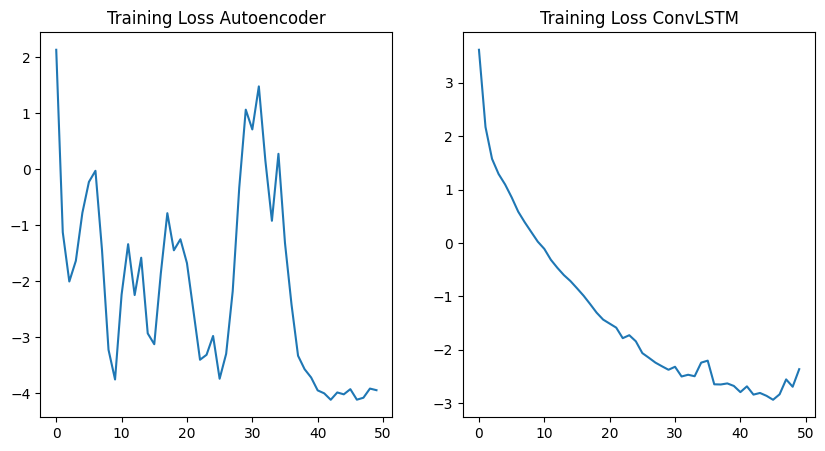

In [27]:
# Plot the training loss
fig, (ax1,ax2)= plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(jnp.log(bilinearAE_train_losses), label='Bilinear AE')
ax2.plot(jnp.log(convLSTM_train_losses), label='ConvLSTM')
ax1.set_title('Training Loss Autoencoder')
ax2.set_title('Training Loss ConvLSTM')
plt.show()

In [28]:
class GradSolver:
    def __init__(self, prior_cost, obs_cost, grad_mod, n_step, lr_grad=0.2):
        self.prior_cost = prior_cost
        self.obs_cost = obs_cost
        self.grad_mod = grad_mod
        self.n_step = n_step
        self.lr_grad = lr_grad

    def init_state(self, batch, x_init=None):
        if x_init is not None:
            return x_init

        # Assume `batch.input` is a JAX array
        return jnp.nan_to_num(batch.input).astype(jnp.float32)

    def solver_step(self, state, batch, step):
        # Compute the cost
        var_cost = self.prior_cost(state) + self.obs_cost(state, batch)

        # Compute gradient w.r.t state
        grad_cost = jax.grad(lambda s: self.prior_cost(s) + self.obs_cost(s, batch))(state)

        # Apply gradient modification
        gmod = self.grad_mod(grad_cost)

        # Compute state update
        state_update = (1 / (step + 1)) * gmod + self.lr_grad * (step + 1) / self.n_step * grad_cost

        # Return updated state
        return state - state_update

    def forward(self, batch):
        # Initialize state
        state = self.init_state(batch)

        # Reset the gradient mod state (this assumes that grad_mod has a reset_state function)
        self.grad_mod.reset_state(batch.input)

        # Iteratively update the state with solver steps
        for step in range(self.n_step):
            state = self.solver_step(state, batch, step)
            # Detach if not in training mode (JAX doesn't have an explicit detach, but we can prevent updating during inference)
            if not self.training:
                state = jax.lax.stop_gradient(state)

        # If not in training mode, apply prior cost forward_ae
        if not self.training:
            state = self.prior_cost.forward_ae(state)

        return state

        return state - state_update

    def forward(self, batch):
        # Initialize state
        state = self.init_state(batch)

        # Reset the gradient mod state (this assumes that grad_mod has a reset_state function)
        self.grad_mod.reset_state(batch.input)

        # Iteratively update the state with solver steps
        for step in range(self.n_step):
            state = self.solver_step(state, batch, step)
            # Detach if not in training mode (JAX doesn't have an explicit detach, but we can prevent updating during inference)
            if not self.training:
                state = jax.lax.stop_gradient(state)

        # If not in training mode, apply prior cost forward_ae
        if not self.training:
            state = self.prior_cost.forward_ae(state)

        return state


In [29]:
grad_solver= GradSolver(prior_cost= model_prior, obs_cost= model_prior, grad_mod= grad_model, n_step= 10, lr_grad= 0.2)

### References
* The repository with the full PyTorch implementation: https://github.com/CIA-Oceanix/4dvarnet-starter
* The first paper by Fablet et.al. (2021), where the 4DVarNet framework was first introduced: https://agupubs.onlinelibrary.wiley.com/doi/pdfdirect/10.1029/2021ms002572
* A repository containing a starting point for  the implementation of 4DVarNet  in JAX:
https://github.com/jejjohnson/jejeqx/tree/48489d643b3722638d8e4e20d3e32393b1a580a5
